# Collaboration and Competition

### Starting the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import torch

from unityagents import UnityEnvironment
from maddpg import MADDPG

Algorithm will train with GPU


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
agents_ids = np.arange(num_agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])
print('The state for the second agent looks like:\n', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like:
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


In [5]:
def generate_full(array):
    return np.concatenate((array[0], array[1])).reshape(1, -1)

def train(n_episodes=2500, max_t=1000, print_every=100):
    # Variables to keep data from training
    scores_deque = deque(maxlen=100) # To calculate average score over last 100 episodes
    average_scores = []              # To save average score of episodes during training
    scores_episode = []              # To save score by episode
    scores_agents = []
    solved = False                   # To check if the environment is solved
    best_average_score = -1          # To save the best_average_score
    episode_best_average_score = -1  # To save the episode with the best_average_score
    best_score = -1
    episode_best_score = -1
    
    # Training loop
    i_episode = 0
    while i_episode <= n_episodes:
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                 # Get the first state
        state_full = generate_full(states)                    # Generate the state_full (concatenation of the state of agent 1 and 2)
        maddpg.reset()                                        # Reset noise function
        scores = np.zeros(num_agents)                         # Generate a array to save scores of each agent during episode
        for t in range(max_t):
            actions = maddpg.act(states, add_noise=True)      # Get action of each agent for the current state (of each agent)
            action_full = generate_full(actions)
            env_info = env.step(actions)[brain_name]          # Execute the current set of actions in the environment
            next_states = env_info.vector_observations        # Get the new state after executed the current set of actions
            next_state_full = generate_full(next_states)
            rewards = env_info.rewards                        # Get the rewareds from executing the current set of actions in the states
            dones = env_info.local_done                       # Check if the episode has ended
            for state, action, reward, next_state, done, agent_id in zip(states, actions, rewards, next_states, dones, agents_ids):
                maddpg.step(state_full, action_full, next_state_full, state, action, reward, next_state, done, t, agent_id)  # Add data to memory and call the learning function
            states = next_states
            state_full = generate_full(states)
            scores += rewards
            if np.any(done):
                break
        scores_agents.append(scores)
        score = np.max(scores)
        if score > best_score:
            best_score = score
            episode_best_score = i_episode
        
        scores_episode.append(score)
        scores_deque.append(score)
        
        average_score = np.mean(scores_deque)
        if average_score > best_average_score:
            best_average_score = average_score
            episode_best_average_score = i_episode
            maddpg.save(model_name="checkpoint_solution")
        
        average_scores.append(np.mean(scores_deque))
        
        print('\rEpisode {}\tScore : {:.2f}\tAverage Score: {:.4f}\tScore Agent_1: {:.2f}\tScore Agent_2: {:.2f}'
              .format(i_episode, score, average_score, scores[1], scores[2]), end="")
        
        if i_episode % print_every == 0 and i_episode > 0:
            maddpg.save()
            print('\rEpisode {}\tScore : {:.2f}\tAverage Score: {:.4f}'.format(i_episode, score, average_score))
        
        if i_episode >= 100 and average_score >= 0.5 and not solved:
            solved = True
            best_average_score = average_score
            episode_best_average_score = i_episode
            
            print("\n\nEnviroment solved in {} episodes!".format(i_episode))
            
            n_episodes = i_episode + 500
            print("Continuing training for more 500 episodes (until episode {}) to see if we can still improve average score!\n".format(n_episodes))
                    
        i_episode += 1
            
    print("\nTraining done!\n")
    print("Best score: {:.3f}".format(best_score))
    print("Episode with best score: {}".format(episode_best_score))
    print("Best average score: {:.3f}".format(best_average_score))
    print("Episode with best average score: {}".format(episode_best_average_score))

    
    return average_scores, scores_episode, scores_agents, solved

Training with seed 2784214
Episode 100	Score : 0.00	Average Score: 0.0047
Episode 200	Score : 0.00	Average Score: 0.0038
Episode 300	Score : 0.00	Average Score: 0.0087
Episode 400	Score : 0.00	Average Score: 0.0078
Episode 500	Score : 0.00	Average Score: 0.0068
Episode 600	Score : 0.00	Average Score: 0.0108
Episode 700	Score : 0.00	Average Score: 0.0090
Episode 800	Score : 0.00	Average Score: 0.0050
Episode 900	Score : 0.00	Average Score: 0.0059
Episode 1000	Score : 0.00	Average Score: 0.0048
Episode 1100	Score : 0.00	Average Score: 0.0050
Episode 1200	Score : 0.00	Average Score: 0.0040
Episode 1300	Score : 0.00	Average Score: 0.0059
Episode 1400	Score : 0.00	Average Score: 0.0089
Episode 1500	Score : 0.00	Average Score: 0.0078
Episode 1600	Score : 0.00	Average Score: 0.0058
Episode 1700	Score : 0.00	Average Score: 0.0067
Episode 1800	Score : 0.00	Average Score: 0.0079
Episode 1900	Score : 0.00	Average Score: 0.0040
Episode 2000	Score : 0.00	Average Score: 0.0088
Episode 2100	Score : 0

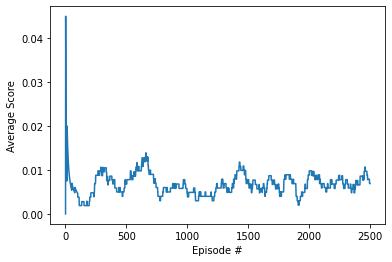

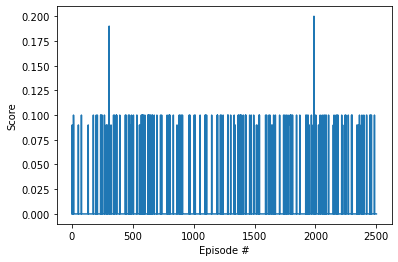

Wall time: 9min 45s


In [6]:
%%time

seed = 2784214
maddpg = MADDPG(state_size=state_size,
                action_size=action_size,
                state_size_full=state_size*2,
                action_size_full=action_size*2,
                random_seed=seed)

print("Training with seed {}".format(seed))

average_scores, scores_episode, solved = train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_episode)+1), scores_episode)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()